In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [10]:
include("../src/SailorMoon.jl")   # relative path to main file of module
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)
gr()
fs = 16;


┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector{T} where T}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


In [11]:
### PARAMETERS ###################################
# csv file to load the initial solution
ig_file  = "../run/data/diffcorr_0618_maxJCThrust2.csv"
opt_file = "../run/data/opt_0618_maxJCThrust.csv"

# dv_dir function corresponding to the csv file 
dir_func = SailorMoon.dv_maxJC_dir_sb1frame

n_arc = 5


# load initial guess
df_ig  = CSV.read(ig_file, DataFrame; header=0);
df_opt = CSV.read(opt_file, DataFrame; header=0);


### plot the optimized trajectory

In [18]:
row_opt = df_opt[2,:]
x = Float64.(collect(row_opt[4:end]))
t_, u_, th_  = SailorMoon.x2time_series(x, dir_func, paramMulti, true);
u_array = [u_[:,i] for i in collect(1:size(u_,2))]

θm_lpo = x[19+12*paramMulti.n_arc]  
# thrust_param_nomi = [1.0, 0.0, 0.0]
# th_nominal = get_thrust(t_, u_array, thrust_param_nomi, θm_lpo, dir_func)
# th_nominal = hcat(th_nominal...)

2.717814052612561

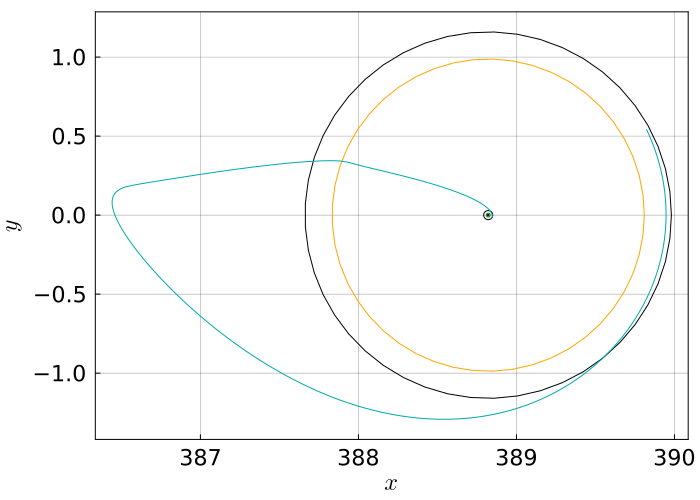

In [19]:
moon     = SailorMoon.plot_circle(1-param3b.mu2, param3b.as , 0.0)
earth    = SailorMoon.plot_circle(param3b.mu2, param3b.as, 0.0)
earth_ub = SailorMoon.plot_circle(param3b.mu2+6375/param3b.lstar, param3b.as, 0.0)
earth_lb = SailorMoon.plot_circle(param3b.mu2-6375/param3b.lstar, param3b.as, 0.0)
moon_soi_outer = SailorMoon.plot_circle(1-param3b.mu2+66000/param3b.lstar, param3b.as, 0.0);


p = plot(
    size=(700,500), frame_style=:box, aspect_ratio=:equal, grid=0.4, legend=false, 
    xlabel=L"x", 
    ylabel=L"y",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

plot!(p, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(p, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(p, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(p, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(p, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer")
plot!(p,u_[1,:], u_[2,:])


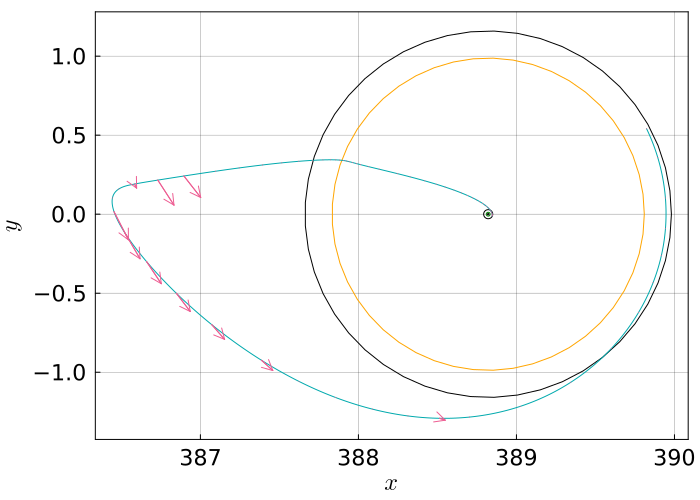

In [20]:
k = size(u_,2)
m = 20
quiver!(p,u_[1,collect(1:m:k)], u_[2,collect(1:m:k)], quiver=(th_[1,collect(1:m:k)]/10, th_[2,collect(1:m:k)]/10))

### Now put the initial guess (diff-corr) trajectory 

In [21]:
ig_id = Int(row_opt[1])
ig_id = 2
row_ig = df_ig[ig_id,:]
x = Float64.(collect(row_ig[4:end]))
t_ig, u_ig, th_ig  = SailorMoon.x2time_series(x, dir_func, paramMulti, false);


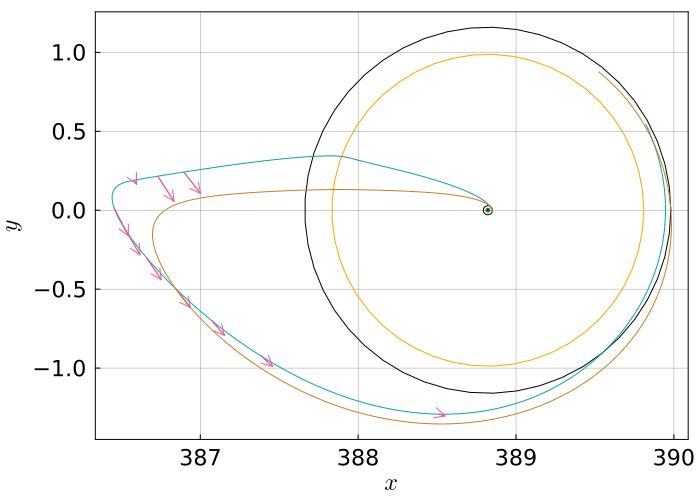

In [22]:
plot!(p,u_ig[1,:], u_ig[2,:])

In [23]:
savefig("optim_traj=sample2.png")

"C:\\Users\\yujit\\Documents\\github\\SailorMoon.jl\\tests_yuji\\optim_traj=sample2.png"